In [807]:
import numpy as np
import pandas as pd

In [808]:
data = pd.read_csv("../datasets/cleaned_data3.csv")

In [809]:
print(data.columns)
unique_counts = data.nunique()

# Display the result
print(unique_counts)

Index(['Energy_Use_Intensity', 'Building_Activity', 'Work_Hours',
       'Percent_Lit_Off_Hours', 'Number_Workers', 'Number_Desktops',
       'Percent_Cooled', 'Main_Heat_Equip', 'Main_Cool_Equp',
       'Floor_Ceiling_Height', 'Number_business'],
      dtype='object')
Energy_Use_Intensity     6356
Building_Activity          20
Work_Hours                143
Percent_Lit_Off_Hours      72
Number_Workers            356
Number_Desktops           256
Percent_Cooled             86
Main_Heat_Equip            35
Main_Cool_Equp             12
Floor_Ceiling_Height       41
Number_business            65
dtype: int64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Building_Activity', ylabel='Count'>

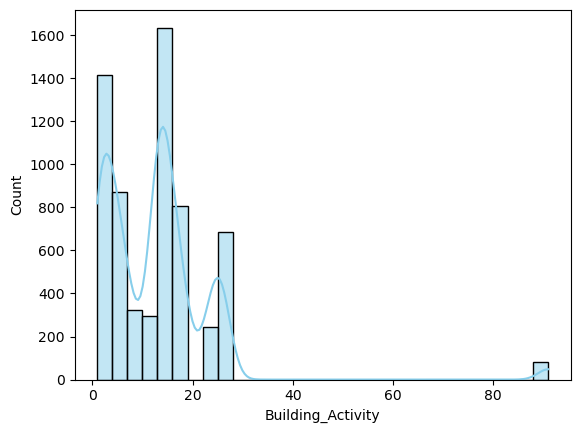

In [810]:
sns.histplot(data["Building_Activity"], kde=True, bins= 30, color='skyblue')
# data['Building_Activity'] = (data['Building_Activity'] / 10).astype(int)

# data['Building_Activity'] = data['Building_Activity'].astype('category')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Building_Activity', ylabel='Count'>

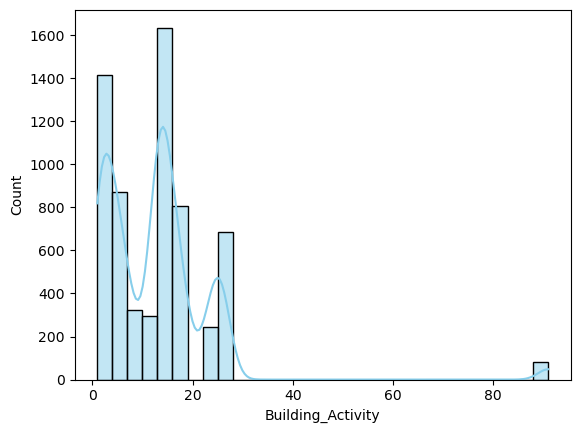

In [811]:
sns.histplot(data["Building_Activity"], kde=True, bins= 30, color='skyblue')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


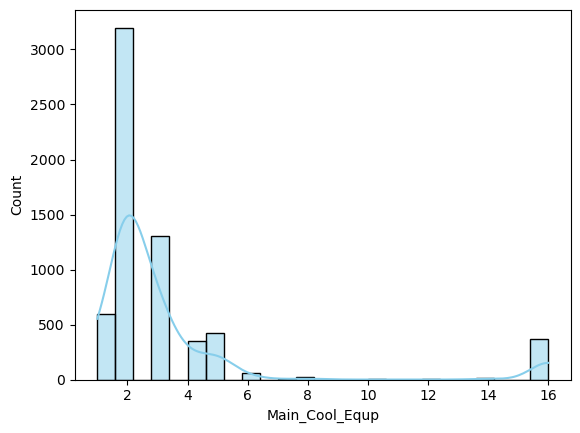

In [812]:
sns.histplot(data["Main_Cool_Equp"], kde=True, bins= 25, color='skyblue')
data['Main_Cool_Equp'] = (data['Main_Cool_Equp'] / 4).astype(int)

data['Main_Cool_Equp'] = data['Main_Cool_Equp'].astype('category')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Main_Cool_Equp', ylabel='Count'>

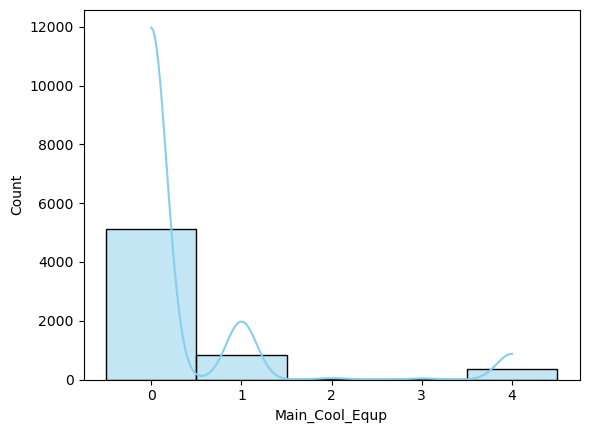

In [813]:
sns.histplot(data["Main_Cool_Equp"], kde=True, bins= 25, color='skyblue')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


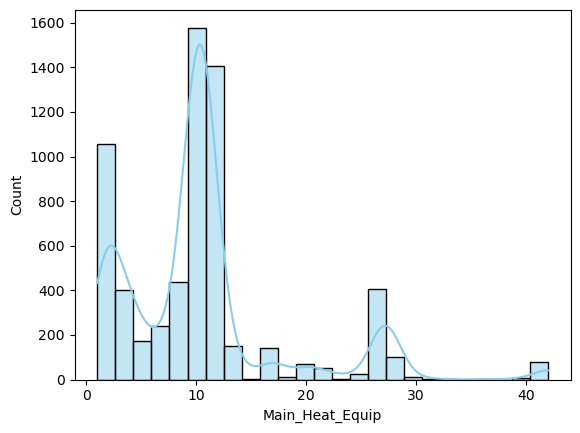

In [814]:
sns.histplot(data["Main_Heat_Equip"], kde=True, bins= 25, color='skyblue')
data['Main_Heat_Equip'] = (data['Main_Heat_Equip'] / 10).astype(int)

data['Main_Heat_Equip'] = data['Main_Heat_Equip'].astype('category')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Main_Heat_Equip', ylabel='Count'>

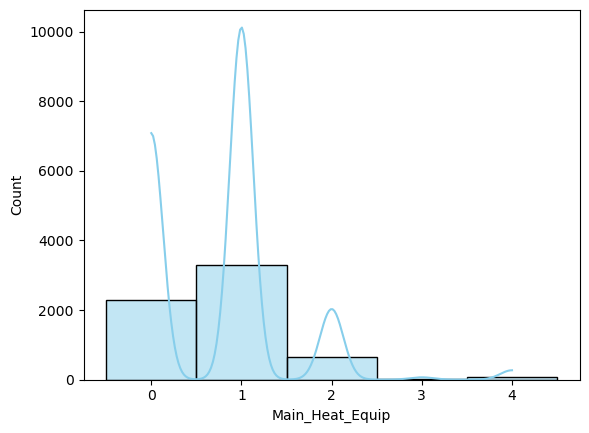

In [815]:
sns.histplot(data["Main_Heat_Equip"], kde=True, bins= 25, color='skyblue')


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Number_business', ylabel='Count'>

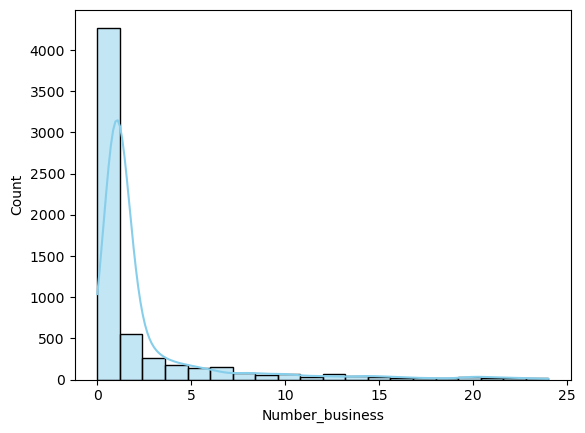

In [816]:

sns.histplot(data["Number_business"][data["Number_business"]<25], kde=True, bins= 20, color='skyblue')


In [817]:

cat_cols = ["Main_Cool_Equp", "Main_Heat_Equip", "Building_Activity"]
cont_cols = ['Energy_Use_Intensity', 'Work_Hours',
       'Percent_Lit_Off_Hours', 'Number_Workers', 'Number_Desktops',
       'Percent_Cooled',
       'Floor_Ceiling_Height', 'Number_business']
target_col = "Energy_Use_Intensity"
columns =  cat_cols + cont_cols

In [818]:
def show_unique_values(df, cat_cols, verbose = True):
        """
        Prints the unique values for each categorical column in the DataFrame.
        
        Args:
        - df: DataFrame to inspect.
        - cat_cols: List of categorical column names.
        """
        if verbose : 
            print("-----------------[ Unique Values in Categorical Columns ]-----------------")
            for col in cat_cols:
                unique_vals = df[col].dropna().unique()  # Drop NaN values to exclude them
                print(f"{col}: {unique_vals.tolist()}")
                print(f"Total Unique (excluding NaN): {len(unique_vals)}\n")


def dataSummary(df, cat_cols, cont_cols , verbose = True):
    if verbose:
        print("------------------------[ Shape ]------------------------\n", df.shape)
        print("------------------------[ Head ]------------------------\n",df.head)
        print("------------------------[ Columns ]------------------------\n",df.columns)
        print("------------------------[ describe ]------------------------\n",df.describe())
        missing_values = df.isnull().sum()
        print("------------------------[ Missing ]------------------------\n", missing_values)
        unique_counts = df.apply(lambda col: col.nunique(dropna=True))
        print("------------------------[ Unique Count ]------------------------\n", unique_counts)
        show_unique_values(df,cat_cols, verbose)
    
    
dataSummary(data[columns], cat_cols, cont_cols, True)
df = data[columns]

------------------------[ Shape ]------------------------
 (6357, 11)
------------------------[ Head ]------------------------
 <bound method NDFrame.head of      Main_Cool_Equp Main_Heat_Equip  Building_Activity  Energy_Use_Intensity  \
0                 0               2                2.0             89.090333   
1                 1               1                2.0             54.595250   
2                 0               0                8.0             24.946190   
3                 0               1                5.0              8.226062   
4                 0               1                5.0              4.374793   
...             ...             ...                ...                   ...   
6352              0               1               18.0             28.536689   
6353              0               1               14.0             18.098746   
6354              0               0                2.0             96.348180   
6355              0               0       

In [819]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def round_to_nearest_category(df, cat_cols, category_map):
    """
    Rounds imputed values in categorical columns to the nearest valid category.
    
    Args:
    - df: DataFrame with imputed values.
    - cat_cols: List of categorical column names.
    - category_map: Dictionary with column names as keys and valid categories as values.
    
    Returns:
    - DataFrame with corrected categorical columns.
    """
    for col in cat_cols:
        valid_categories = np.array(category_map[col])
        df[col] = df[col].apply(lambda x: valid_categories[np.abs(valid_categories - x).argmin()])
    return df

def remove_outliers(df, cols):
    """
    Removes outliers from the specified columns in the DataFrame
    using the Interquartile Range (IQR) method.
    
    Parameters:
        df (DataFrame): Input DataFrame
        cols (list): List of column names to check for outliers
        
    Returns:
        DataFrame: DataFrame without outliers
    """
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)  
        IQR = Q3 - Q1                
        lower_bound = Q1 - 1.5 * IQR 
        upper_bound = Q3 + 1.5 * IQR 
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df

def DataPreProcessing(df, cat_cols, cont_cols, category_map):
    
    df = df.dropna(subset=[target_col]).copy()
    
    # columns_to_check = ['SQFT', 'Number_Workers', 'Number_desktops', 'Cooling_Days', 'Work_hours', target_col]
    columns_to_check = [ target_col, "Percent_Lit_Off_Hours", "Floor_Ceiling_Height", "Number_business"]
    
    df = remove_outliers(df, columns_to_check)
    # df[target_col] = np.log1p(df[target_col])
    # df[target_col] = df[target_col]**3
    from scipy import stats
    df[target_col], _ = stats.boxcox(df[target_col] + 1)
    df["Work_Hours"] = np.log1p(df["Work_Hours"])
    df["Work_Hours"] = df["Work_Hours"]**3
    df["Percent_Lit_Off_Hours"] = np.log1p(df["Percent_Lit_Off_Hours"])
    df["Number_Workers"] = np.log1p(df["Number_Workers"])
    df["Number_Desktops"] = np.log1p(df["Number_Desktops"])
    
    df["Percent_Cooled"] = df["Percent_Cooled"]**10
    
    # df["Percent_Cooled"], _ = stats.boxcox(df["Percent_Cooled"] + 1)
    
    df["Floor_Ceiling_Height"] = np.log1p(df["Floor_Ceiling_Height"])
    df["Number_business"] = np.sqrt(df["Number_business"])
    
    
    from scipy.stats import boxcox
    # df[target_col], fitted_lambda = boxcox(df[target_col])

    imputer = KNNImputer(n_neighbors=15)
    df_imputed = pd.DataFrame(imputer.fit_transform(df[cat_cols + cont_cols]), columns=cat_cols + cont_cols)
    df_imputed = round_to_nearest_category(df_imputed, cat_cols, category_map)
    
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    
    df_imputed[cont_cols] = scaler.fit_transform(df_imputed[cont_cols])

    return df_imputed, scaler


def DataPreProcessingMedianMode(df, cat_cols, cont_cols):
    """
    Preprocesses data by handling missing values:
    - Fills continuous columns with the median.
    - Fills categorical columns with the mode.
    - Normalizes continuous columns.

    Args:
    - df: DataFrame to process.
    - cat_cols: List of categorical column names.
    - cont_cols: List of continuous column names.

    Returns:
    - df_processed: DataFrame after preprocessing.
    - scaler: Fitted scaler object for continuous columns.
    """
    df_processed = df.copy()
    
    for col in cont_cols:
        median_val = df_processed[col].median()
        df_processed[col].fillna(median_val, inplace=True)
    
    for col in cat_cols:
        mode_val = df_processed[col].mode()[0]
        df_processed[col].fillna(mode_val, inplace=True)
    
    scaler = MinMaxScaler()
    df_processed[cont_cols] = scaler.fit_transform(df_processed[cont_cols])

    return df_processed, scaler

category_map = {
    'Building_Activity': [0, 1, 2, 5, 4, 3],
    'Main_Cool_Equp': [0, 1, 4, 2, 3],
    'Main_Heat_Equip': [2, 1, 0, 4, 3],
}


df_imputed, scaler = DataPreProcessing(df, cat_cols, cont_cols, category_map)

dataSummary(df_imputed, cat_cols, cont_cols)

------------------------[ Shape ]------------------------
 (4400, 11)
------------------------[ Head ]------------------------
 <bound method NDFrame.head of       Main_Cool_Equp  Main_Heat_Equip  Building_Activity  \
0                  0                2                  2   
1                  1                1                  2   
2                  0                0                  5   
3                  0                1                  5   
4                  0                0                  5   
...              ...              ...                ...   
4395               0                1                  5   
4396               4                2                  2   
4397               0                1                  5   
4398               0                1                  5   
4399               0                0                  5   

      Energy_Use_Intensity  Work_Hours  Percent_Lit_Off_Hours  Number_Workers  \
0                 0.851536    0.573749  

In [820]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

class DataExploration:
    def __init__(self, df, cat_cols, cont_cols, target_col, output_dir='eda_plots_after_transformed'):
        self.df = df.copy()
        self.cat_cols = cat_cols
        self.cont_cols = cont_cols
        self.target_col = target_col
        self.output_dir = output_dir

        # Create the output directory if it doesn't exist
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def freedman_diaconis_bins(self, data):
        """Calculate optimal bin size using the Freedman-Diaconis rule"""
        data = data.replace([np.inf, -np.inf], np.nan).dropna()
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        n = len(data)
        bin_width = 2 * iqr / n**(1/3)
        
        if bin_width == 0:
            return 1  # Default to 1 bin if bin_width is zero
        
        bins = int((data.max() - data.min()) / bin_width)
        return bins

    def plot_histograms_with_qq(self):
        """Plot histograms and Q-Q plots side by side for each continuous feature."""
        plt.figure(figsize=(16, 22))  # Increased height for better spacing
        
        for i, col in enumerate(self.cont_cols):
            bins = self.freedman_diaconis_bins(self.df[col].dropna())
    
            # Create a subplot for histogram and Q-Q plot side by side
            plt.subplot(len(self.cont_cols), 2, 2*i + 1)
            sns.histplot(self.df[col], kde=True, bins=bins, color='skyblue')
            plt.title(f'Histogram of {col}')
            
            # Q-Q plot
            plt.subplot(len(self.cont_cols), 2, 2*i + 2)
            stats.probplot(self.df[col].dropna(), dist="norm", plot=plt)
            plt.title(f'Q-Q Plot of {col}')
        
        plt.tight_layout()
        save_path = os.path.join(self.output_dir, 'histograms.png')
        plt.savefig(save_path)
        plt.close()
        print(f"Histograms and Q-Q plots saved to {save_path}")


    def plot_pairplot(self):
        pairplot = sns.pairplot(self.df, vars=self.cont_cols, hue=self.target_col, palette='coolwarm')
        pairplot.fig.suptitle(f"Pairplot of Continuous Columns Against {self.target_col}", y=1.02)
        save_path = os.path.join(self.output_dir, 'pairplot.png')
        pairplot.savefig(save_path)
        plt.close()
        print(f"Pairplot saved to {save_path}")

    def plot_boxplots(self):
        plt.figure(figsize=(16, 12))
        for i, col in enumerate(self.cat_cols):
            plt.subplot(3, 4, i + 1)
            sns.boxplot(x=self.df[col], y=self.df[self.target_col], palette='Set2')
            plt.title(f'Box plot of {col} vs {self.target_col}')
            plt.xticks(rotation=45)
        plt.tight_layout()
        save_path = os.path.join(self.output_dir, 'boxplots.png')
        plt.savefig(save_path)
        plt.close()
        print(f"Boxplots saved to {save_path}")

    def plot_pie_charts(self):
        plt.figure(figsize=(16, 12))
        for i, col in enumerate(self.cat_cols):
            plt.subplot(3, 4, i + 1)
            self.df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
            plt.title(f'Pie chart for {col}')
            plt.ylabel('')
        plt.tight_layout()
        save_path = os.path.join(self.output_dir, 'pie_charts.png')
        plt.savefig(save_path)
        plt.close()
        print(f"Pie charts saved to {save_path}")

    def plot_correlation_matrix(self):
        corr_matrix = self.df[self.cont_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title("Correlation Matrix of Continuous Columns")
        save_path = os.path.join(self.output_dir, 'correlation_matrix.png')
        plt.savefig(save_path)
        plt.close()
        print(f"Correlation matrix saved to {save_path}")

    def perform_eda(self):
        self.plot_histograms_with_qq()  # Using the new method that includes Q-Q plots
        self.plot_pairplot()
        self.plot_boxplots()
        self.plot_pie_charts()
        self.plot_correlation_matrix()


# Example usage:
eda = DataExploration(df_imputed.copy(), cat_cols, cont_cols, target_col=target_col)
eda.perform_eda()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

Histograms and Q-Q plots saved to eda_plots_after_transformed/histograms.png


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

Pairplot saved to eda_plots_after_transformed/pairplot.png
Boxplots saved to eda_plots_after_transformed/boxplots.png
Pie charts saved to eda_plots_after_transformed/pie_charts.png
Correlation matrix saved to eda_plots_after_transformed/correlation_matrix.png


In [821]:
import pandas as pd

def one_hot_encode(df, cat_cols, target_col):
    """
    Performs one-hot encoding on specified categorical columns and converts boolean to 1 and 0.

    Args:
    - df: DataFrame to encode.
    - cat_cols: List of categorical column names to one-hot encode.
    - target_col: The target column to exclude from encoding.

    Returns:
    - df_encoded: DataFrame with one-hot encoded columns (0 and 1).
    """
    df = df.copy()
    
    cat_cols = [col for col in cat_cols if col != target_col]
    
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    for col in df_encoded.columns:
        if df_encoded[col].dtype == bool:
            df_encoded[col] = df_encoded[col].astype(int)

    print(f"Shape after one-hot encoding: {df_encoded.shape}")
    
    return df_encoded

df_encoded = one_hot_encode(df_imputed, cat_cols, target_col)
df_encoded[target_col]

Shape after one-hot encoding: (4400, 19)


0       0.851536
1       0.688000
2       0.478087
3       0.266811
4       0.654349
          ...   
4395    0.459747
4396    0.769456
4397    0.510113
4398    0.407683
4399    0.738264
Name: Energy_Use_Intensity, Length: 4400, dtype: float64

In [790]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def feature_engineering(df, cat_cols, cont_cols, target_colm, poly_degree = 1):
    """
    Enhances a DataFrame by adding interaction terms, log, and polynomial transformations
    for the continuous columns, while leaving the target column unchanged.

    Args:
    - df: DataFrame to process.
    - cat_cols: List of categorical column names.
    - cont_cols: List of continuous column names.
    - target_col: Name of the target column (to remain unchanged).

    Returns:
    - df_transformed: DataFrame with new features added.
    """
    df_transformed = df.copy()
    
    cont_cols_no_target = [col for col in cont_cols if col != target_col]
    
    # for col1, col2 in combinations(cont_cols_no_target, 2):
    #     interaction_col_name = f"{col1}_x_{col2}"
    #     df_transformed[interaction_col_name] = df_transformed[col1] * df_transformed[col2]
    
    for col in cont_cols_no_target:
        log_col_name = f"log_{col}"
        df_transformed[log_col_name] = np.log1p(df_transformed[col])  # Use log1p to avoid log(0) errors
    
    poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
    poly_features = poly.fit_transform(df_transformed[cont_cols_no_target])
    poly_feature_names = poly.get_feature_names_out(cont_cols_no_target)
    
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df_transformed.index)
    df_transformed = pd.concat([df_transformed, poly_df], axis=1)
    
    df_transformed[target_col] = df[target_col]
    
    # print(f"Shape after feature engineering: {df_transformed.shape}")
    return df_transformed

df_transformed = feature_engineering(df_encoded.copy(), cat_cols, cont_cols, target_col,2)

In [833]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def run_ols(df, target_col, verbose= True):
    """
    Runs an OLS regression and finds significant features based on p-values.
    
    Args:
    - df_encoded: DataFrame containing encoded features and target column.
    - target_col: The name of the target column (dependent variable).
    
    Returns:
    - significant_features: List of features that are statistically significant.
    """
    X = df.drop(columns=[target_col])  # Features
    y = df[target_col]  # Target variable
    
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)
    y = y.loc[X.index]  # Align target column with cleaned X
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    summary = model.summary()
    if verbose: print(summary)
    
    p_values = model.pvalues
    significant_features = p_values[p_values < 0.05].index.tolist()
    
    if 'const' in significant_features:
        significant_features.remove('const')
    
    return significant_features

significant_features = run_ols(df_transformed, target_col, True)
print(f"Significant features: {significant_features}")


                             OLS Regression Results                             
Dep. Variable:     Energy_Use_Intensity   R-squared:                       0.371
Model:                              OLS   Adj. R-squared:                  0.350
Method:                   Least Squares   F-statistic:                     18.32
Date:                  Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                          16:10:18   Log-Likelihood:                 1867.7
No. Observations:                  4400   AIC:                            -3459.
Df Residuals:                      4262   BIC:                            -2578.
Df Model:                           137                                         
Covariance Type:              nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [785]:
def remove_duplicate_columns(df):
    """
    Removes duplicate columns from a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with duplicate columns removed.
    """
    # Transpose the DataFrame to compare columns as rows
    df_T = df.T

    # Drop duplicate columns based on their content
    df_T = df_T.drop_duplicates(keep='first')

    # Transpose back to original orientation
    df_no_value_duplicates = df_T.T

    # Remove duplicate column names (if any)
    df_no_name_duplicates = df_no_value_duplicates.loc[:, ~df_no_value_duplicates.columns.duplicated()]

    return df_no_name_duplicates

# Apply the updated function
df_transformed = remove_duplicate_columns(df_encoded)


In [786]:
significant_features = list(set(significant_features))
l = significant_features + [target_col]
l.sort()
l

['Building_Activity_2',
 'Building_Activity_4',
 'Building_Activity_5',
 'Energy_Use_Intensity',
 'Floor_Ceiling_Height^2',
 'Main_Heat_Equip_1',
 'Main_Heat_Equip_2',
 'Number_Desktops Number_business',
 'Number_Workers Number_business',
 'Number_Workers Percent_Cooled',
 'Number_Workers^2',
 'Percent_Cooled^2',
 'Percent_Lit_Off_Hours Floor_Ceiling_Height',
 'Work_Hours Floor_Ceiling_Height',
 'Work_Hours Number_Workers',
 'Work_Hours^2',
 'log_Floor_Ceiling_Height',
 'log_Number_Workers',
 'log_Percent_Cooled',
 'log_Work_Hours']

In [822]:
from sklearn.model_selection import train_test_split
df_encoded_features = list(df_encoded.columns)
df_encoded_features.remove(target_col)
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded[df_encoded_features], df_encoded[target_col], test_size=0.2, random_state=42
)

Fitting 5 folds for each of 1344 candidates, totalling 6720 fits
Best Parameters: {'alpha': 0.2, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error: 0.0257
R-squared Score: 0.3673


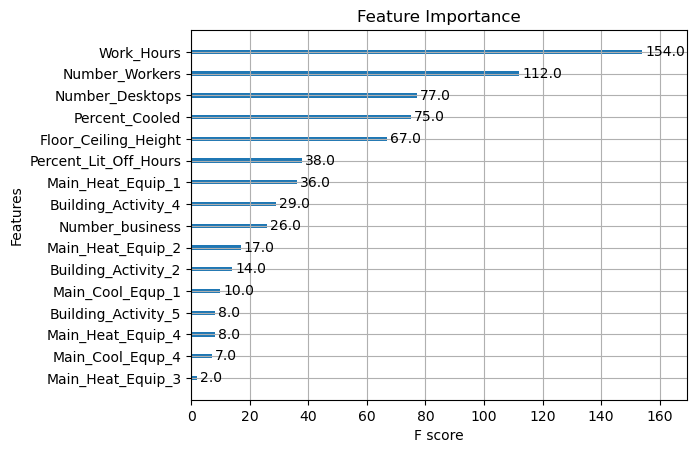

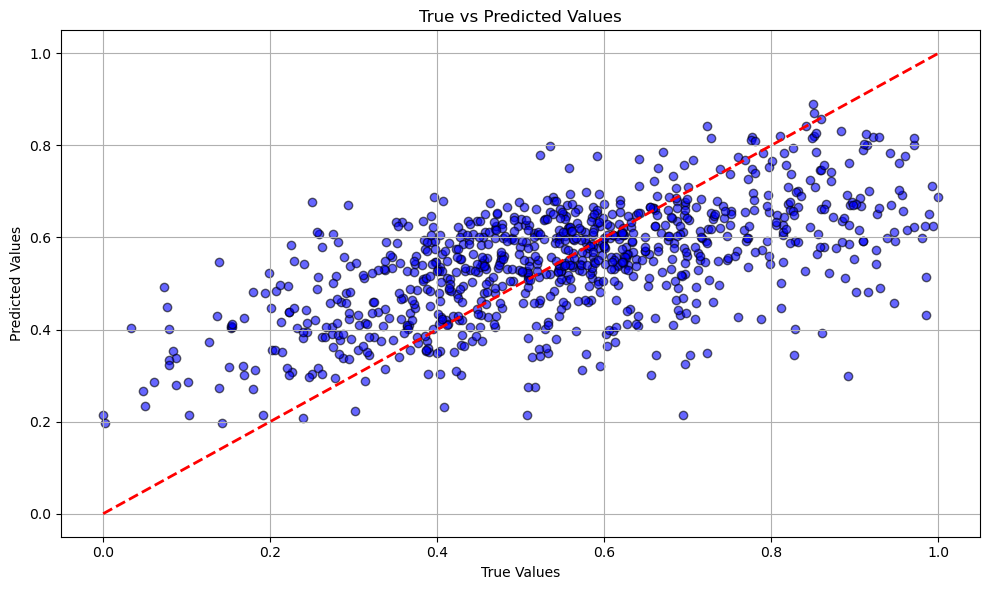

In [824]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'colsample_bytree': [0.3, 0.5, 0.7],     # Fraction of features used per tree
    'learning_rate': [0.01, 0.1, 0.2, 0.3],       # Step size shrinkage
    'max_depth': [3, 5, 7, 9],                  # Maximum depth of trees
    'n_estimators': [50, 100, 200, 300],          # Number of boosting rounds
    'alpha': [0.1, 0.2, 0.4,0.5, 1, 10, 100]                    # Regularization term
}


# Initialize the XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',   # Use negative MSE as the metric
    cv=5,                              # 3-fold cross-validation
    verbose=1,                         # Print progress
    n_jobs=-1                          # Use all available cores
)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")





import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(best_model, importance_type='weight')
plt.title('Feature Importance')
plt.show()

import matplotlib.pyplot as plt

# Scatter plot for True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line of perfect prediction
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()



In [831]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Save summary plot as PNG
shap.summary_plot(shap_values, X_test, show=False)  # Disable immediate display
plt.savefig("shap_summary_plot.png", bbox_inches="tight", dpi=300)  # Save as PNG
plt.close()

# Save force plot for a specific instance
force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

# Save the force plot as an HTML file
shap.save_html("shap_force_plot.html", force_plot)

# Optional: Convert HTML to PNG (requires an additional library)
# from html2image import Html2Image
# hti = Html2Image()
# hti.screenshot(html_file="shap_force_plot.html", save_as="shap_force_plot.png")


In [832]:
import pandas as pd
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

# Convert SHAP values to a DataFrame for summary
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Calculate mean absolute SHAP value for each feature
shap_summary = shap_df.abs().mean().sort_values(ascending=False)

# Print the SHAP summary
print("SHAP Feature Importance Summary:")
print(shap_summary.head(10))  # Display the top 10 features


SHAP Feature Importance Summary:
Work_Hours               0.053387
Percent_Cooled           0.030052
Number_Workers           0.029063
Main_Heat_Equip_1        0.015071
Percent_Lit_Off_Hours    0.013247
Building_Activity_2      0.007322
Number_Desktops          0.006374
Floor_Ceiling_Height     0.006284
Number_business          0.003911
Main_Heat_Equip_2        0.003586
dtype: float32


                  Generalized Linear Model Regression Results                   
Dep. Variable:     Energy_Use_Intensity   No. Observations:                 3520
Model:                              GLM   Df Residuals:                     3500
Model Family:                  Gaussian   Df Model:                           19
Link Function:                 Identity   Scale:                        0.027085
Method:                            IRLS   Log-Likelihood:                 1366.8
Date:                  Sat, 07 Dec 2024   Deviance:                       94.799
Time:                          15:22:28   Pearson chi2:                     94.8
No. Iterations:                       3   Pseudo R-squ. (CS):             0.3733
Covariance Type:              nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

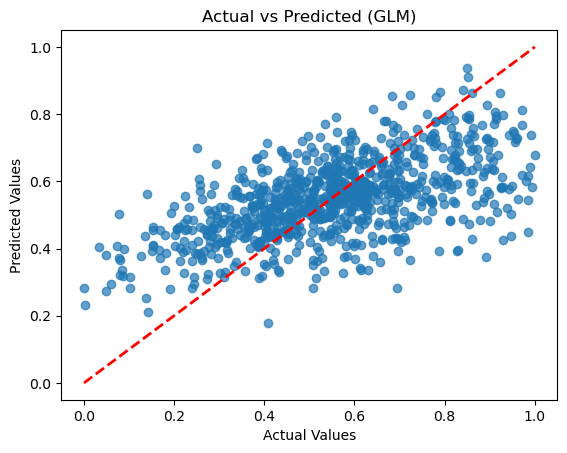

In [794]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Add an intercept to the model
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the GLM
glm = sm.GLM(y_train, X_train_sm, family=sm.families.Gaussian())
glm_results = glm.fit()

# Model summary
print(glm_results.summary())

# Predictions
y_pred = glm_results.predict(X_test_sm)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Scatter plot of predictions vs actual
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line of perfect prediction

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (GLM)")
plt.show()


Final MSE loss: 0.0269


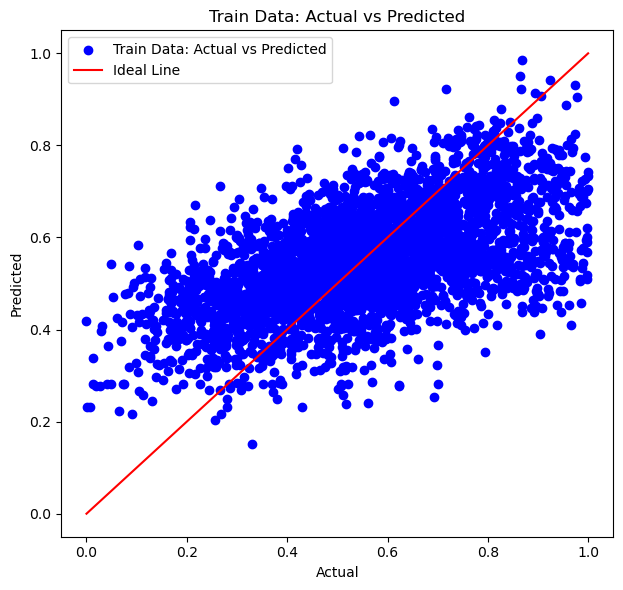

Train Accuracy: R2 = 0.3197, MSE = 0.0269
Test Accuracy: R2 = 0.3402, MSE = 0.0268


(0.3196772997626077,
 0.02693150490541466,
 0.34023682691081014,
 0.026845971549362243)

In [795]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

class LinearRegressionModel:
    def __init__(self, df, target_col):
        """
        Initialize the model with data and columns.
        df: DataFrame, data including both features and target
        target_col: str, the name of the target column (dependent variable)
        cat_cols: list, categorical columns (if any)
        cont_cols: list, continuous columns (if any)
        """
        self.df = df
        self.target_col = target_col
        
        self.X = self.df.drop(columns=[self.target_col])
        self.y = self.df[target_col]
        
        self.model = LinearRegression()
        
    def fit(self, X_train, y_train):
        """
        Fit the linear regression model using sklearn's LinearRegression.
        X_train: Features for training
        y_train: Target variable for training
        """
        self.model.fit(X_train, y_train)
        
    def predict(self, X):
        """
        Predict the target variable for a given input matrix X.
        """
        return self.model.predict(X)

    def plot_metrics(self, X_train, y_train):
        """
        Plot loss over epochs and Test vs Predicted values.
        """
        train_pred = self.predict(X_train)
        
        loss = mean_squared_error(y_train, train_pred)
        print(f'Final MSE loss: {loss:.4f}')
        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, train_pred, color='blue', label='Train Data: Actual vs Predicted')
        plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', label='Ideal Line')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Train Data: Actual vs Predicted')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def accuracy(self, X_train, y_train, X_test, y_test):
        """
        Calculate the R2, MSE, and Accuracy (train and test).
        """
        train_pred = self.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        
        test_pred = self.predict(X_test)
        test_r2 = r2_score(y_test, test_pred)
        test_mse = mean_squared_error(y_test, test_pred)

        print(f'Train Accuracy: R2 = {train_r2:.4f}, MSE = {train_mse:.4f}')
        print(f'Test Accuracy: R2 = {test_r2:.4f}, MSE = {test_mse:.4f}')
        
        return train_r2, train_mse, test_r2, test_mse




model = LinearRegressionModel(df_transformed, target_col)
model.fit(X_train, y_train)

model.plot_metrics(X_train, y_train)
model.accuracy(X_train, y_train, X_test, y_test)


Train Metrics:
MSE: 0.0269
MAE: 0.1296
R2: 0.3195
Adjusted R2: 0.3158
MAPE: 72.8539%

Test Metrics:
MSE: 0.0269
MAE: 0.1293
R2: 0.3397
Adjusted R2: 0.3251
MAPE: 328523189.1915%



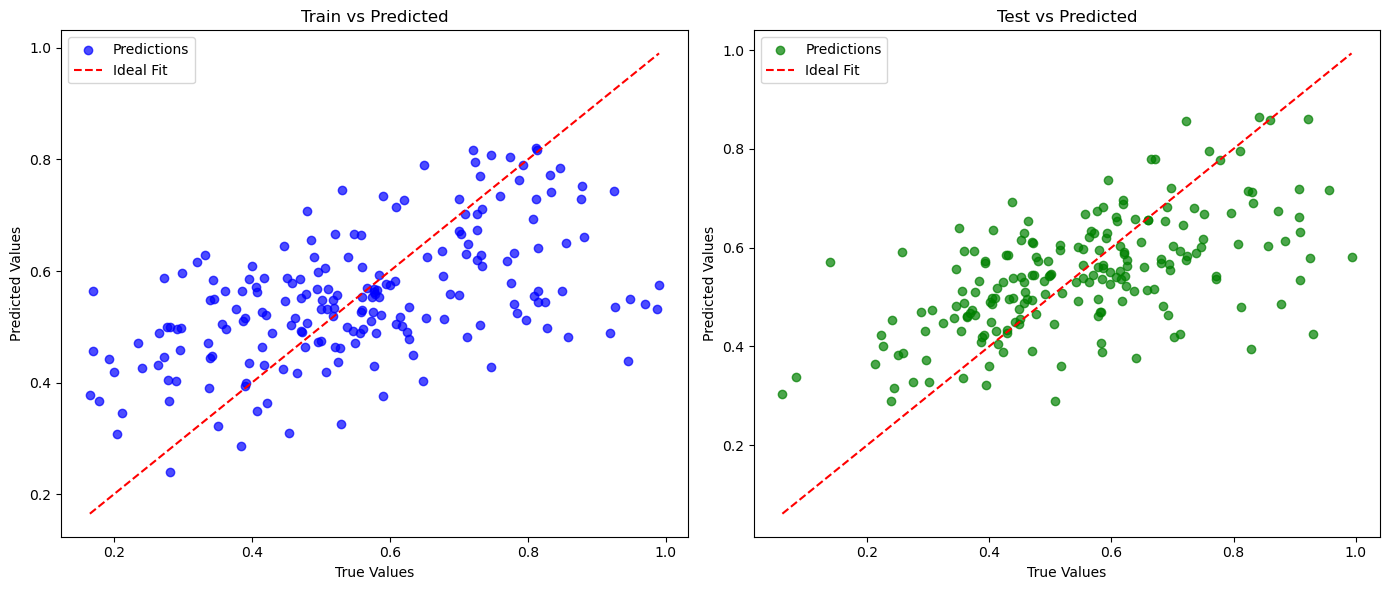

In [796]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

class RidgeModel:
    def __init__(self, alpha=1.0):
        """
        Initialize the Ridge regression model.
        
        Args:
        - alpha (float): Regularization strength (default is 1.0).
        """
        self.alpha = alpha
        self.model = Ridge(alpha=self.alpha)

    def train(self, X_train, y_train):
        """
        Train the Ridge regression model on the training data.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        """
        self.model.fit(X_train, y_train)

    def predict(self, X):
        """
        Make predictions using the trained Ridge regression model.
        
        Args:
        - X (DataFrame): The feature matrix for which predictions are made.
        
        Returns:
        - y_pred (array): The predicted values.
        """
        return self.model.predict(X)

    def evaluate(self, X_train, y_train, X_test, y_test, verbose= True):
        """
        Evaluate the model's performance on both train and test datasets.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        - X_test (DataFrame): The feature matrix for testing.
        - y_test (Series): The target variable for testing.
        
        Prints:
        - MSE, MAE, R2, Adjusted R2, and MAPE.
        """
        
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        r2_train = r2_score(y_train, y_train_pred)
        n_train = X_train.shape[0]
        p_train = X_train.shape[1]
        adjusted_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)
        
        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        r2_test = r2_score(y_test, y_test_pred)
        n_test = X_test.shape[0]
        p_test = X_test.shape[1]
        adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
        
        mape_train = np.mean(np.abs((y_train - y_train_pred) / (y_train + 1e-10))) * 100  # Add small epsilon to avoid division by zero
        mape_test = np.mean(np.abs((y_test - y_test_pred) / (y_test + 1e-10))) * 100  # Add small epsilon to avoid division by zero
        if verbose:
            print("Train Metrics:")
            print(f"MSE: {mse_train:.4f}")
            print(f"MAE: {mae_train:.4f}")
            print(f"R2: {r2_train:.4f}")
            print(f"Adjusted R2: {adjusted_r2_train:.4f}")
            print(f"MAPE: {mape_train:.4f}%\n")
            
            print("Test Metrics:")
            print(f"MSE: {mse_test:.4f}")
            print(f"MAE: {mae_test:.4f}")
            print(f"R2: {r2_test:.4f}")
            print(f"Adjusted R2: {adjusted_r2_test:.4f}")
            print(f"MAPE: {mape_test:.4f}%\n")
        return mse_train, mse_test, r2_train, r2_test

    
    def plot_predictions(self, X_train, y_train, X_test, y_test):
        """
        Plot train vs predicted and test vs predicted values with variability reference.
        
        Args:
        - X_train (DataFrame): The feature matrix for training.
        - y_train (Series): The target variable for training.
        - X_test (DataFrame): The feature matrix for testing.
        - y_test (Series): The target variable for testing.
        """
        # Predictions
        y_train_pred = self.predict(X_train)
        y_test_pred = self.predict(X_test)
        
        # Calculate residuals and variability
        train_residuals = y_train - y_train_pred
        test_residuals = y_test - y_test_pred
        train_std = train_residuals.std()
        test_std = test_residuals.std()
        
        # Plot Train vs Predicted with Variability
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(y_train, y_train_pred, color='blue', alpha=0.7, label='Predictions')
        plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--', label='Ideal Fit')
        plt.title("Train vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        
        # Plot Test vs Predicted with Variability
        plt.subplot(1, 2, 2)
        plt.scatter(y_test, y_test_pred, color='green', alpha=0.7, label='Predictions')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
        plt.title("Test vs Predicted")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        
        plt.tight_layout()
        plt.show()



ridge_model = RidgeModel(alpha=1.0)
ridge_model.train(X_train, y_train)

mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test ,True)
n_for_plot = 200


ridge_model.plot_predictions(X_train[:n_for_plot], y_train[:n_for_plot], X_test[:n_for_plot], y_test[:n_for_plot])


### Manual tuning

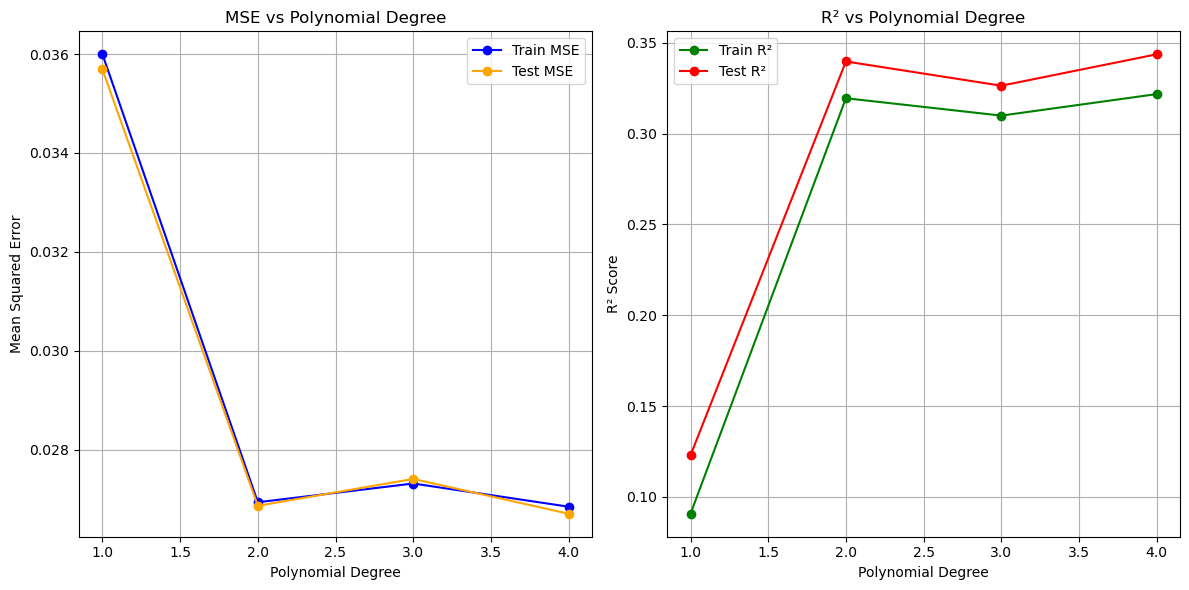

In [797]:
import matplotlib.pyplot as plt

# Lists to store results
mse_train_results = []
mse_test_results = []
r2_train_results = []
r2_test_results = []

poly_degrees = [1, 2, 3, 4]

for d in poly_degrees:
    # Generate polynomial features of the current degree
    df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=d)
    
    # Identify significant features using OLS
    significant_features = run_ols(df_transformed, target_col, False)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df_transformed[significant_features], df_transformed[target_col], test_size=0.2, random_state=42
    )
    
    # Initialize and train the Ridge model
    ridge_model = RidgeModel(alpha=1.0)
    ridge_model.train(X_train, y_train)
    
    # Evaluate the model
    mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, False)
    
    # Save metrics
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)
    

# Plot MSE and R² for training and testing sets
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(poly_degrees, mse_train_results, marker='o', label='Train MSE', color='blue')
plt.plot(poly_degrees, mse_test_results, marker='o', label='Test MSE', color='orange')
plt.title('MSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(poly_degrees, r2_train_results, marker='o', label='Train R²', color='green')
plt.plot(poly_degrees, r2_test_results, marker='o', label='Test R²', color='red')
plt.title('R² vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- Right Degree is 2

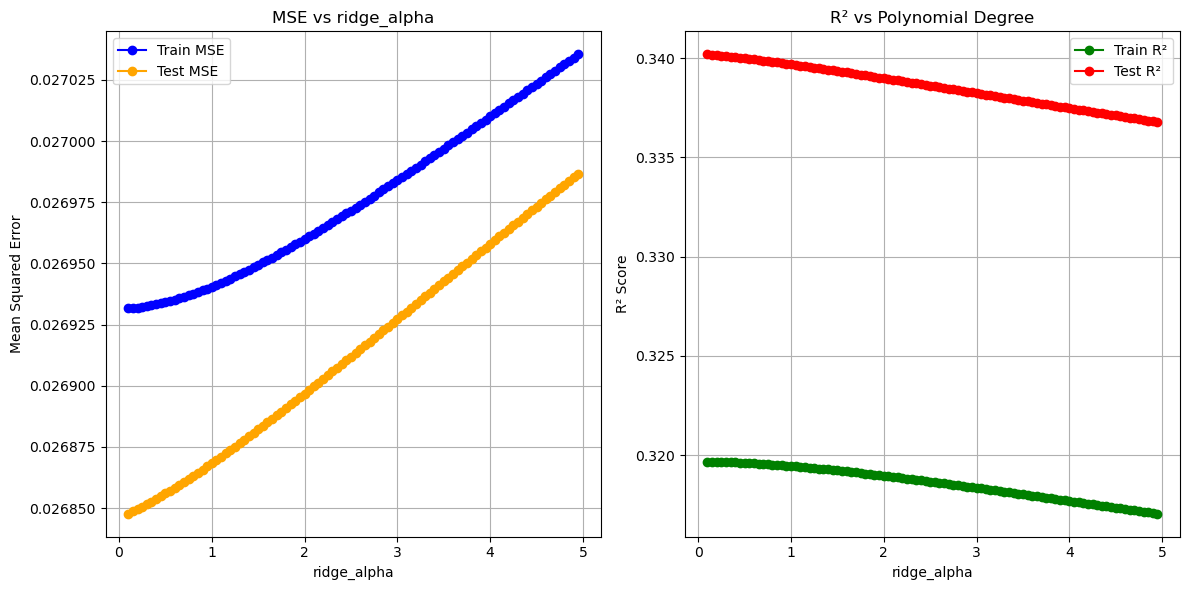

In [798]:
import matplotlib.pyplot as plt

# Lists to store results
mse_train_results = []
mse_test_results = []
r2_train_results = []
r2_test_results = []

ridge_alpha = np.arange(0.1, 5, 0.05)
# ridge_alpha = [10, 100, 1000]

for alpha in ridge_alpha:
    # Generate polynomial features of the current degree
    df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=2)
    
    # Identify significant features using OLS
    significant_features = run_ols(df_transformed, target_col, False)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df_transformed[significant_features], df_transformed[target_col], test_size=0.2, random_state=42
    )
    
    # Initialize and train the Ridge model
    ridge_model = RidgeModel(alpha=alpha)
    ridge_model.train(X_train, y_train)
    
    # Evaluate the model
    mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, False)
    
    # Save metrics
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)
    
# Plot MSE and R² for training and testing sets
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(ridge_alpha, mse_train_results, marker='o', label='Train MSE', color='blue')
plt.plot(ridge_alpha, mse_test_results, marker='o', label='Test MSE', color='orange')
plt.title('MSE vs ridge_alpha')
plt.xlabel('ridge_alpha')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(ridge_alpha, r2_train_results, marker='o', label='Train R²', color='green')
plt.plot(ridge_alpha, r2_test_results, marker='o', label='Test R²', color='red')
plt.title('R² vs Polynomial Degree')
plt.xlabel('ridge_alpha')
plt.ylabel('R² Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- Right Alpha for RidgeModel 0.2

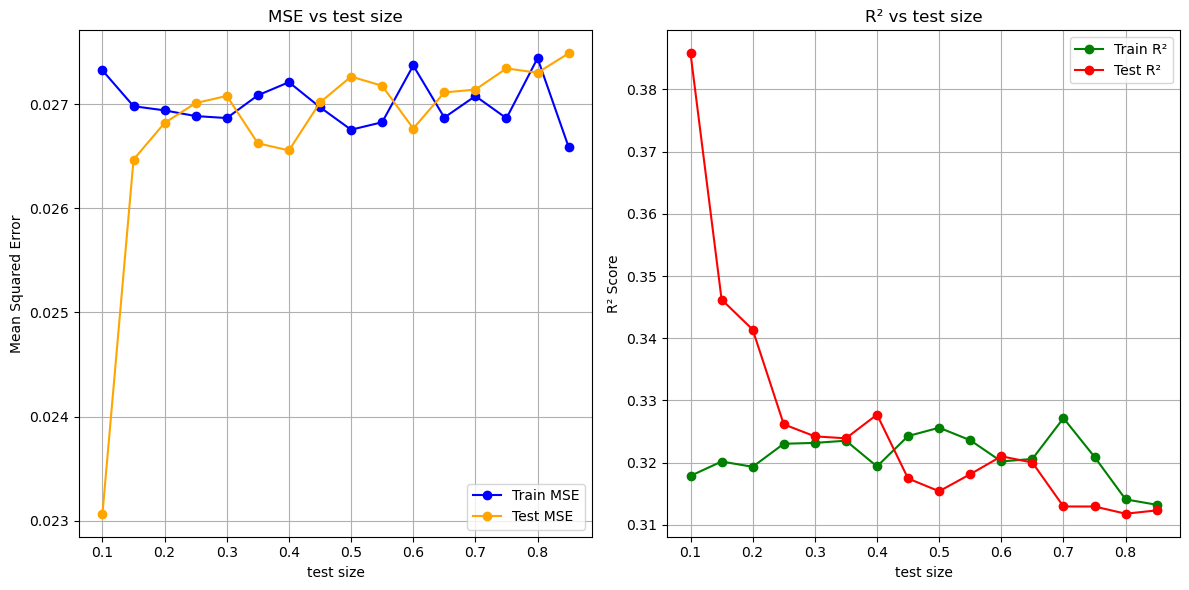

In [799]:
import matplotlib.pyplot as plt

# Lists to store results
mse_train_results = []
mse_test_results = []
r2_train_results = []
r2_test_results = []

test_split = np.arange(0.1, 0.9, 0.05)
# ridge_alpha = [10, 100, 1000]

for t_ in test_split:
    # Generate polynomial features of the current degree
    df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=2)
    
    # Identify significant features using OLS
    significant_features = run_ols(df_transformed, target_col, False)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        df_transformed[significant_features], df_transformed[target_col], test_size=t_, random_state=42
    )
    
    # Initialize and train the Ridge model
    ridge_model = RidgeModel(alpha=0.2)
    ridge_model.train(X_train, y_train)
    
    # Evaluate the model
    mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, False)
    
    # Save metrics
    mse_train_results.append(mse_train)
    mse_test_results.append(mse_test)
    r2_train_results.append(r2_train)
    r2_test_results.append(r2_test)
    
# Plot MSE and R² for training and testing sets
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(test_split, mse_train_results, marker='o', label='Train MSE', color='blue')
plt.plot(test_split, mse_test_results, marker='o', label='Test MSE', color='orange')
plt.title('MSE vs test size')
plt.xlabel('test size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid()

# Plot R²
plt.subplot(1, 2, 2)
plt.plot(test_split, r2_train_results, marker='o', label='Train R²', color='green')
plt.plot(test_split, r2_test_results, marker='o', label='Test R²', color='red')
plt.title('R² vs test size')
plt.xlabel('test size')
plt.ylabel('R² Score')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


- Right test split size 0.25

Train Metrics:
MSE: 0.0271
MAE: 0.1299
R2: 0.3165
Adjusted R2: 0.3102
MAPE: 76.2591%

Test Metrics:
MSE: 0.0273
MAE: 0.1300
R2: 0.3201
Adjusted R2: 0.3011
MAPE: 258985090.7891%



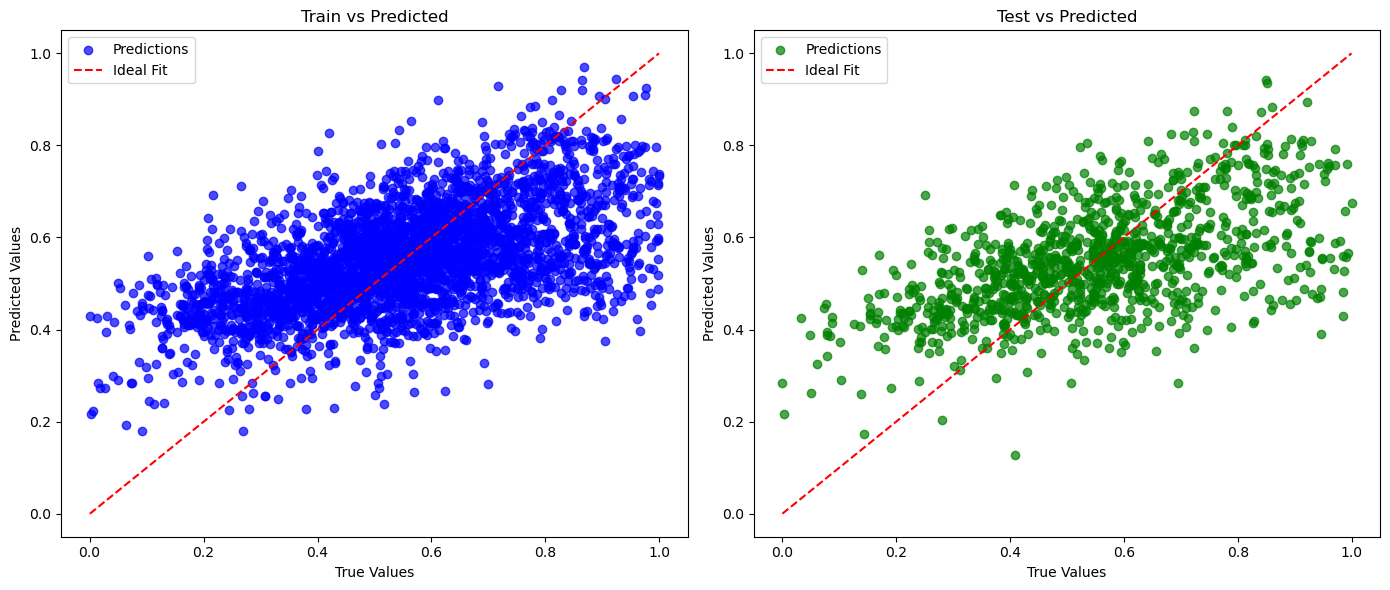

In [800]:
df_transformed = feature_engineering(df_encoded, cat_cols, cont_cols, target_col, poly_degree=3)

significant_features = run_ols(df_transformed, target_col, False)

X_train, X_test, y_train, y_test = train_test_split(
    df_transformed[significant_features], df_transformed[target_col], test_size= 0.25, random_state=42
)

ridge_model = RidgeModel(alpha=0.2)
ridge_model.train(X_train, y_train)

mse_train, mse_test, r2_train, r2_test = ridge_model.evaluate(X_train, y_train, X_test, y_test, True)
n_for_plot = -1

ridge_model.plot_predictions(X_train[:n_for_plot], y_train[:n_for_plot], X_test[:n_for_plot], y_test[:n_for_plot])


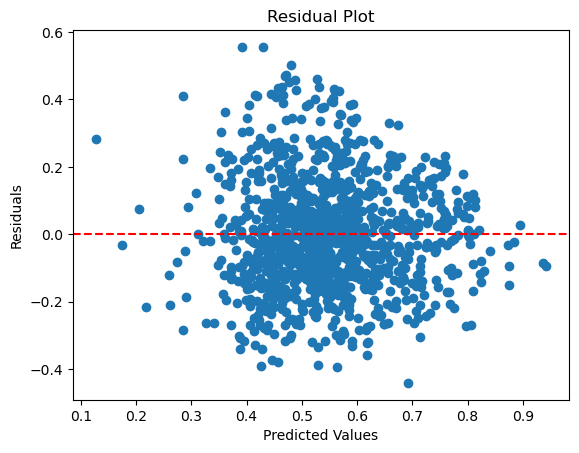

In [801]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = ridge_model.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [802]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")



R² Score: 0.32014247737453994


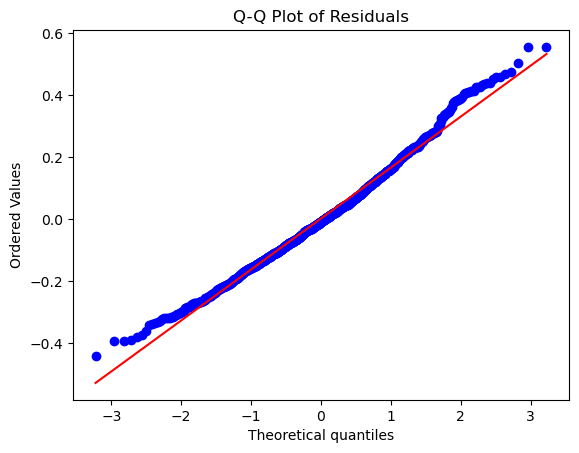

In [803]:
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


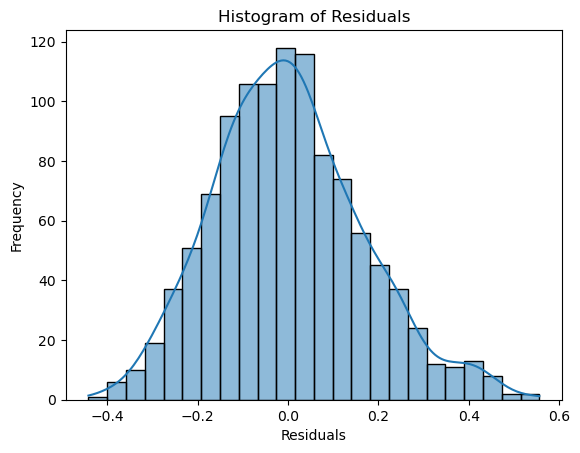

In [804]:
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [805]:
ridge_model.model

Ridge(alpha=0.2)

In [806]:
# Assuming ridge_model is already trained
import pandas as pd

# Feature names (if available)
feature_names = X_train.columns  # Replace with your actual feature names if using a DataFrame

# Extract coefficients
ridge_coefficients = ridge_model.model.coef_

# Combine feature names and coefficients into a DataFrame for better visualization
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_coefficients
})

# Sort coefficients by their absolute values for better interpretation
coeff_df = coeff_df.sort_values(by='Coefficient', key=abs, ascending=False)
print(coeff_df)


                                              Feature  Coefficient
12                                   Percent_Cooled^2    -0.554685
9                                    Number_Workers^2    -0.469311
7                           Work_Hours Number_Workers     0.441888
16                        Work_Hours Number_Workers^2    -0.393191
28                                   Percent_Cooled^3     0.385689
27                  Number_Desktops Number_business^2    -0.352958
6                                  log_Percent_Cooled     0.338749
25             Number_Desktops^2 Floor_Ceiling_Height     0.304444
22                                   Number_Workers^3     0.302380
13                Percent_Cooled Floor_Ceiling_Height     0.298549
3                                 Building_Activity_4     0.294248
29              Percent_Cooled^2 Floor_Ceiling_Height    -0.291738
11                    Number_Desktops Number_business     0.244439
10               Number_Desktops Floor_Ceiling_Height    -0.23

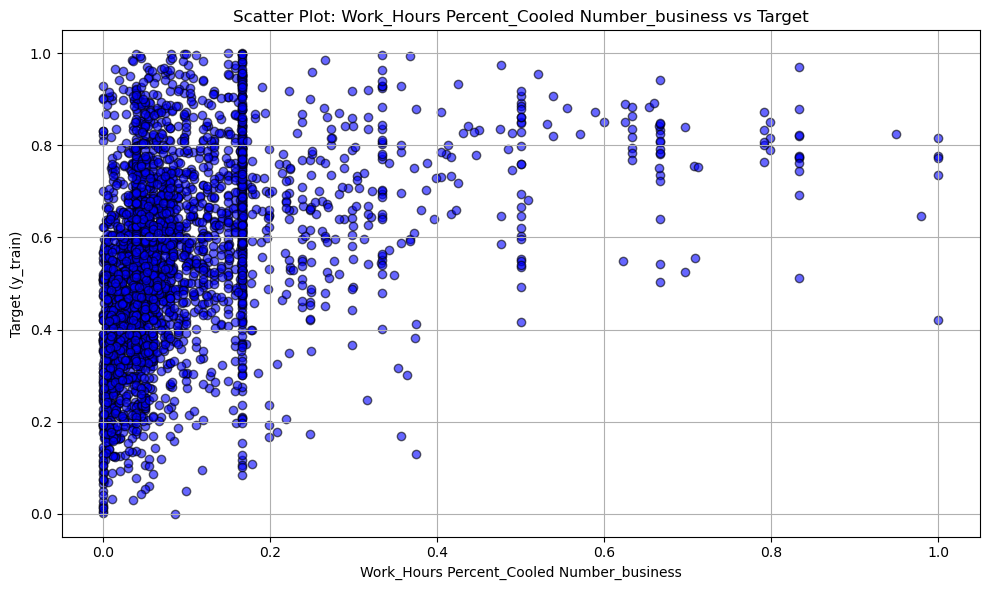

In [584]:
import matplotlib.pyplot as plt

# Scatter plot for selected feature vs target
plt.figure(figsize=(10, 6))
plt.scatter(X_train["Work_Hours Percent_Cooled Number_business"], y_train, color='blue', alpha=0.6, edgecolor='k')
plt.title('Scatter Plot: Work_Hours Percent_Cooled Number_business vs Target')
plt.xlabel('Work_Hours Percent_Cooled Number_business')
plt.ylabel('Target (y_train)')
plt.grid(True)
plt.tight_layout()
plt.show()
